## ANOMALY DETECTION

In [1]:
## Import required liabrary
import pandas as pd 
import numpy as np 
import zipfile
import os
import io
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import requests

In [2]:
## Download the dataset
url = 'https://archive.ics.uci.edu/static/public/240/human+activity+recognition+using+smartphones.zip'
zipped_file = "UCI_HAR_Dataset.zip"

In [3]:
## Download and extract the outer ZIP
response = requests.get(url)
if response.status_code == 200:
    with zipfile.ZipFile(io.BytesIO(response.content)) as outer_zip:
        extract_outer = "extracted_outer"
        outer_zip.extractall(extract_outer)  # Extract outer ZIP
        print("Outer ZIP extracted.")

        # Step 2: Find the inner ZIP file
        for file in os.listdir(extract_outer):
            if file.endswith(".zip"):  # Assuming there's one inner ZIP
                inner_zip_path = os.path.join(extract_outer, file)

                # Step 3: Extract the inner ZIP
                with zipfile.ZipFile(inner_zip_path, 'r') as inner_zip:
                    extract_inner = os.path.join(extract_outer, "extracted_inner")
                    inner_zip.extractall(extract_inner)
                    print(f"Inner ZIP '{file}' extracted into '{extract_inner}'")
else:
    print("Failed to download the ZIP file.")

Outer ZIP extracted.
Inner ZIP 'UCI HAR Dataset.zip' extracted into 'extracted_outer\extracted_inner'


In [4]:
## Load fetaures, test data and training data 
features_path = os.path.join(extract_inner, "UCI HAR Dataset", "features.txt")
x_train_path = os.path.join(extract_inner, "UCI HAR Dataset", "train", "X_train.txt")
x_test_path = os.path.join(extract_inner, "UCI HAR Dataset", "test", "X_test.txt")

In [5]:
features_name = pd.read_csv(features_path, sep='\\s+', header=None)
X_train = pd.read_csv(x_train_path, sep='\\s+', header=None)
X_test = pd.read_csv(x_test_path, sep='\\s+', header=None)

In [7]:
## assign features to columns 
column_name = features_name.iloc[:,1].tolist()

In [8]:
X_train.columns = column_name
X_test.columns = column_name

In [11]:
X = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)

In [138]:
## dispaly first five rows
X.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892


In [141]:
## check any missing value is present 
pd.isnull(X).sum()

tBodyAcc-mean()-X                       0
tBodyAcc-mean()-Y                       0
tBodyAcc-mean()-Z                       0
tBodyAcc-std()-X                        0
tBodyAcc-std()-Y                        0
                                       ..
angle(tBodyGyroMean,gravityMean)        0
angle(tBodyGyroJerkMean,gravityMean)    0
angle(X,gravityMean)                    0
angle(Y,gravityMean)                    0
angle(Z,gravityMean)                    0
Length: 561, dtype: int64

In [142]:
# Preprocessing data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(X)
data_scaled


array([[ 2.10533854e-01, -6.87026385e-02, -4.52194533e-01, ...,
        -6.74432366e-01,  3.82007658e-01, -1.61505480e-02],
       [ 6.02084832e-02,  3.59023537e-02, -2.75221885e-01, ...,
        -6.81359801e-01,  3.83147865e-01, -1.20627169e-04],
       [ 7.84597052e-02, -4.64269585e-02, -8.55480582e-02, ...,
        -6.89470939e-01,  3.84288531e-01,  1.92144041e-02],
       ...,
       [ 1.11821625e+00,  1.28805864e+00, -1.29414692e-01, ...,
        -3.10750224e-01,  6.91509049e-01,  8.75719123e-01],
       [-5.43492722e-01,  9.75327452e-01,  2.34319837e-01, ...,
        -3.19283719e-01,  6.59762215e-01,  8.99444350e-01],
       [-1.78515253e+00, -1.86663622e-02, -5.29759691e-01, ...,
        -3.19991245e-01,  6.56994458e-01,  9.01454465e-01]])

In [143]:
## Dimensionality reduction 
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)
pca_df = pd.DataFrame(data_pca, columns=['PC1', 'PC2'])

In [19]:
data_pca

array([[-16.38097982,   1.99508306],
       [-15.58217328,   1.18259412],
       [-15.42398918,   2.24316685],
       ...,
       [ 11.84685312,  -3.43356542],
       [  8.20668637,  -4.38648683],
       [  9.31117251,  -3.98616071]])

## Clustering based Anomaly detection

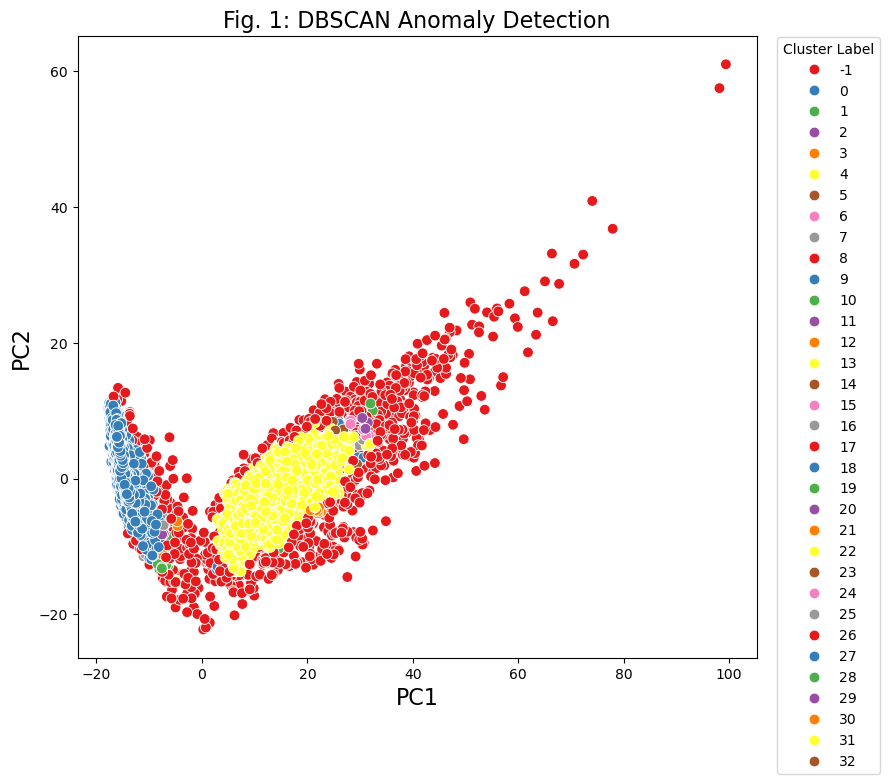

In [135]:
## Clustering-Based Anomaly Detection (DBSCAN) 
dbscan = DBSCAN(eps=0.5, min_samples=5)
db_labels = dbscan.fit_predict(data_pca)

## Identify anomalies (-1 are outlier)
pca_df['DBSCAN_Label'] = db_labels

## Visualize DBSCAN results
plt.figure(figsize=(9,8))
ax = sns.scatterplot(x='PC1', y='PC2', hue='DBSCAN_Label', s=60, data=pca_df, palette='Set1')
plt.title('Fig. 1: DBSCAN Anomaly Detection',fontsize=16)
plt.legend(title='Cluster Label')
plt.xlabel('PC1', fontsize=16)
plt.ylabel('PC2', fontsize=16)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.02, 1.01))
plt.tight_layout()
plt.savefig('dbscan.png')
plt.show()

## K-means Clustering 

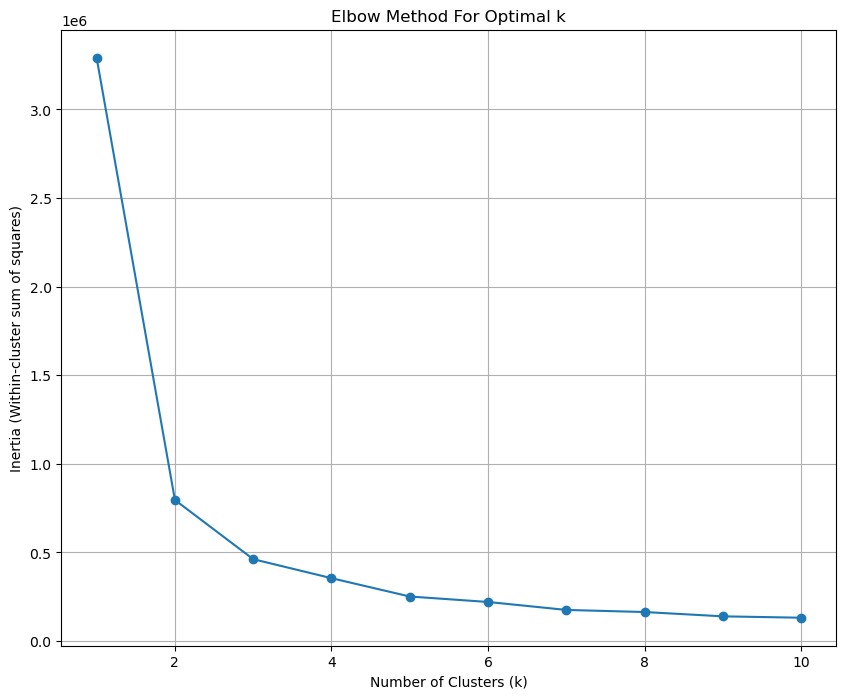

In [144]:
## find optimal value for K using elbow method
wcss = []
k_range = range(1, 11)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(data_pca)
    wcss.append(km.inertia_)

## Plot the elbow method for optimal K
plt.figure(figsize=(10,8))
plt.plot(k_range, wcss, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-cluster sum of squares)')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

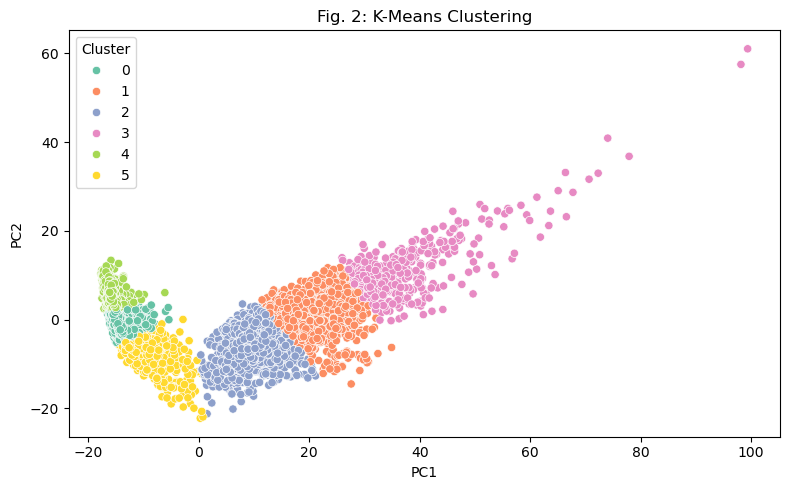

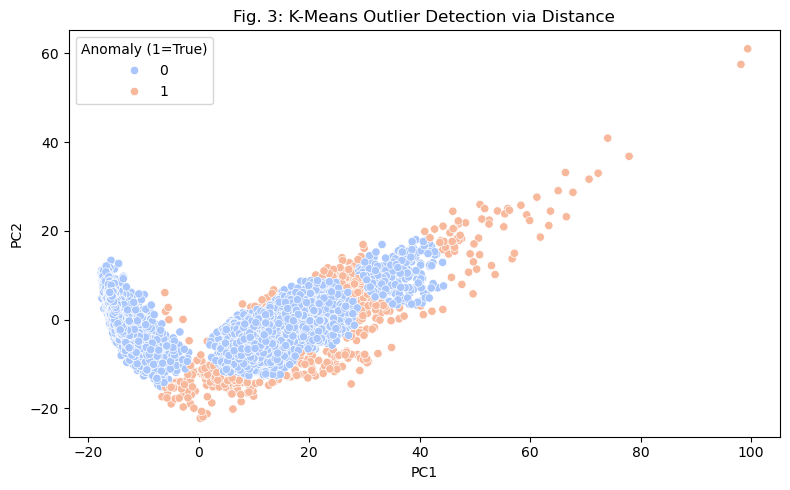

In [148]:
## K-means clustering
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans_labels = kmeans.fit_predict(data_pca)
pca_df['KMeans_Label'] = kmeans_labels

## Distance to centroid for anomaly score
distances = np.linalg.norm(data_pca - kmeans.cluster_centers_[kmeans_labels], axis=1)
pca_df['Distance_to_Centroid'] = distances

## Define top 5% farthest as anomalies
threshold = np.percentile(distances, 95)
pca_df['KMeans_Anomaly'] = (pca_df['Distance_to_Centroid'] > threshold).astype(int)

## Visualize K-Means clustering
plt.figure(figsize=(8, 5))
sns.scatterplot(x='PC1', y='PC2', hue='KMeans_Label', data=pca_df, palette='Set2')
plt.title('Fig. 2: K-Means Clustering')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

## Visualize anomalies from K-Means
plt.figure(figsize=(8, 5))
# plt.subplot(1,2,2)
sns.scatterplot(x='PC1', y='PC2', hue='KMeans_Anomaly', data=pca_df, palette='coolwarm')
plt.title('Fig. 3: K-Means Outlier Detection via Distance')
plt.legend(title='Anomaly (1=True)')
plt.tight_layout()
plt.savefig("kmeans.png")
plt.show()

In [95]:
# Optional: Summary
print(f"DBSCAN found {sum(db_labels == -1)} anomalies.")
print(f"K-Means flagged {sum(pca_df['KMeans_Anomaly'])} points as outliers.")

DBSCAN found 909 anomalies.
K-Means flagged 515 points as outliers.
